# How to get these notebooks to work

Dataset describe here: http://archive.ics.uci.edu/ml/datasets/Online+Retail+II

wget http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

git clone git@github.com:franzoni/proton-Hands-on_task_Senior_Data_Scientist.git

mv online_retail_II.xlsx proton-Hands-on_task_Senior_Data_Scientist

# DATA cleaning and preparation
## repeat the choices already made fr EDA and customers analyes, namely:
- remove nulls
- consider only ordinary transactions
- remove cancellations

In [1]:
import sys, os
import pandas as pd

data_path = os.getcwd()
print('++ Directory of this notebook:')
print('\t%s'%data_path)

excel_with_path  = data_path+'/online_retail_II.xlsx'
pickle_with_path = data_path+'/online_retail_II.pkl'
csv_with_path    = data_path+'/online_retail_II.csv'

print('\n++Full path of the data file:')
print('\tdata_path =%s\n\n'%excel_with_path)

df = None

if os.path.isfile(pickle_with_path):
    print('-> picke already exists, much faster using it than opening excel files\n')
    df = pd.read_pickle(pickle_with_path)
else:
    print('-> picke does not exist, go to excel, and create it\n')
    df1 = pd.read_excel (excel_with_path,'Year 2009-2010')
    df2 = pd.read_excel (excel_with_path,'Year 2010-2011')
    df = pd.concat([df1, df2])
    df.to_pickle(pickle_with_path)
    print('-> picke done\n')
    
df['Transaction'] = df.Quantity * df.Price
df=df.rename(columns={"Customer ID": "Customer_ID"})

# implement the definition of cancellation in the documentation:
# http://archive.ics.uci.edu/ml/datasets/Online+Retail+II
#      ==> "If this code starts with the letter 'c', it indicates a cancellation.""
def is_cancellation(s):
    if isinstance(s, int):
        #print "ordinary invoice"
        return 0
    elif isinstance(s, unicode):
        #print "unicode string"
        #thse are cancellations
        if s.rfind('C')!=-1:
            return 1
        else:
            # print "Something unexpected"  # found, e.g. A506401
            # print s
            return 2
df['IsCancellation'] = df['Invoice'].map(is_cancellation)     
      


# items with prices above ~1500 are so few that is worth looking at them in detail, and excluding them from the plots
# There'a lot of transactions with price set to 0, which based on the descriptions are 
max_item_price=1400
r             =(0,max_item_price)
def is_ordinary_item(p):
    if abs(p)>max_item_price or p==0:
        return 0
    else:
        return 1
df['IsOrdinaryItem'] = df['Price'].map(is_ordinary_item) 

++ Directory of this notebook:
	/eos/home-f/franzoni/SWAN_projects/proton-Hands-on_task_Senior_Data_Scientist

++Full path of the data file:
	data_path =/eos/home-f/franzoni/SWAN_projects/proton-Hands-on_task_Senior_Data_Scientist/online_retail_II.xlsx


-> picke already exists, much faster using it than opening excel files



In [2]:
df.shape

(1067371, 11)

In [3]:
df=df.dropna()
df= df.loc[ (df.IsCancellation==0) & (df.IsOrdinaryItem==1) ]
df.shape

(805520, 11)

In [4]:
df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,IsCancellation,IsOrdinaryItem
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,0,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,0,1


# Analysis STRATEGY: 
- calibrate modelMID up to mid 2011
- check the model against the last 6 months
- modelMID gives the probability of alive/death at mid 2011
- re-calibrate over the whole period, modelFULL
- modelFULL gives the probability of alive/death at end
- question 1: p(Alive, modelMID) is high, p(Alive, modelFULL) is low
- question 2: p(Alive, modelFULL) is somewhat low

## Working notes and documentation

- https://www.kdnuggets.com/2019/05/churn-prediction-machine-learning.html 
- https://towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266
- https://www.google.com/search?q=dwarf+on+the+shoulders+of+giants&rlz=1C5CHFA_enCH771CH771&sxsrf=ALeKk034vLLmAHn5V1c0QAON4DZuO1GqVA:1582207255390&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiRrayrpeDnAhXCxaYKHZQVCgcQ_AUoAXoECBIQAw&biw=1418&bih=915#imgrc=oj4GwW0aHYfVYM
- similar exercise resolved here https://towardsdatascience.com/modeling-customer-churn-for-an-e-commerce-business-with-python-874315e688bf
- the repo of the library to be used https://github.com/CamDavidsonPilon/lifetimes
- the reference paper in pdf http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf http://brucehardie.com/papers/bgnbd_2004-04-20.pdf and the journal which has all aspects of a respectable journals 
- GF TODO: once you've found which customers have churned, make a few hitory plots to prove that indeed they have churned, to show that I am not blindly trusing the package I've downloade


- cancellations: fraction of cancellation by nunber of transactions and by proportion of renenue
-                correlation to CHURNING ? Correlation to country OR type of good purchased ?


- NOT SURE IF USEFUL some stack-overflow like explanations about the Pareto model https://stats.stackexchange.com/questions/251506/is-it-possible-to-understand-pareto-nbd-model-conceptually

In [5]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
from lifetimes.fitters import *

In [80]:
# help(summary_data_from_transaction_data)

In [7]:
columns_forRFM = ['Customer_ID','InvoiceDate','Transaction']
df_forRFM = df[columns_forRFM]
df_forRFM.shape

(805520, 3)

In [8]:
df_forRFM.head(3)

,Customer_ID,InvoiceDate,Transaction
0,13085.0,2009-12-01 07:45:00,83.4
1,13085.0,2009-12-01 07:45:00,81.0
2,13085.0,2009-12-01 07:45:00,81.0


## DOC of function _summary__data__from__transaction__data_
summary_data_from_transaction_data(transactions, customer_id_col, datetime_col, monetary_value_col=None, datetime_format=None, observation_period_end=None, freq='D', freq_multiplier=1)

- Return summary data from transactions.
    
-    This transforms a DataFrame of transaction data of the form:
        customer_id, datetime [, monetary_value]
-    to a DataFrame of the form:
        customer_id, frequency, recency, T [, monetary_value]

In [9]:
# RFM_total is for the total dataset
RFM_total = summary_data_from_transaction_data(df_forRFM, \
                'Customer_ID','InvoiceDate'
                ,monetary_value_col='Transaction',freq='D')
RFM_total.shape

(5875, 4)

In [10]:
RFM_total.head(5)

,frequency,recency,T,monetary_value
Customer_ID,,,,
12346.0,7.0,400.0,725.0,11066.637143
12347.0,7.0,402.0,404.0,717.398571
12348.0,4.0,363.0,438.0,449.310000
12349.0,3.0,571.0,589.0,1120.056667
12350.0,0.0,0.0,310.0,0.000000


<a id="section_ID_getRFM"></a>

## RFM variables: definitions and comments

GENERALLY, the first transaction (aka 'the birth' of the customer) is ecluded from the RFM variables

DEFINITIONS
- Recency: time between initial purchase and most recent (last) purchase
- Frequency: number of repeat purchases made by a customer (total purchases — 1)
- Monetary: total spent on purchases

## FUNCTION summary_data_from_transaction_data
- very useful to computer RFM variables with minimal code re-writing
- it's a rather clever thing: it AGGREGATES into 1 all transactions taking place at the same DAY!

- frequency: # of days in which a customer made a repeat purchase
- T: customer's age in days
- recency: customer's age in days at the time of the most recent purchase
- monetary_value: mean of a customer's purchases, excluding the 1st purchase

In [11]:
# a basic glance at the content
RFM_total.describe()

,frequency,recency,T,monetary_value
count,5875.000000,5875.000000,5875.000000,5875.000000
mean,4.633191,273.487149,474.274383,317.113424
std,9.993993,258.975061,223.072007,2254.409792
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,313.000000,0.000000
50%,2.000000,221.000000,530.000000,213.555000
75%,5.000000,512.000000,668.000000,376.168333
max,253.000000,738.000000,738.000000,168469.600000


# Verifiaction of how summary_data_from_transaction_data
- for a few Customer_Id randomly picked, Frequency makes sense
- the code behaves ok based on the spot-checks, is publicly available https://github.com/CamDavidsonPilon/lifetimes

In [12]:
RFM_total.shape

(5875, 4)

In [13]:
# keep the option of toggling this
if False:
    RFM_total = RFM_total.loc[RFM_total['monetary_value']>0]   \
                        .loc[RFM_total['recency']>0]          \
                        .loc[RFM_total['frequency']>0]        \

In [14]:
RFM_total.shape

(5875, 4)

In [15]:
# df_forRFM[df_forRFM['Customer_ID']==12346.0].sort_values(by=['InvoiceDate'],ascending=False)
#df_forRFM[df_forRFM['Customer_ID']==12346.0].InvoiceDate.unique()
# len(df[df['Customer_ID']==12346.0].InvoiceDate.unique())
df_forRFM[df_forRFM['Customer_ID']==12347.0].InvoiceDate.unique()

array(['2010-10-31T14:20:00.000000000', '2010-12-07T14:57:00.000000000',
       '2011-01-26T14:30:00.000000000', '2011-04-07T10:43:00.000000000',
       '2011-06-09T13:01:00.000000000', '2011-08-02T08:48:00.000000000',
       '2011-10-31T12:25:00.000000000', '2011-12-07T15:52:00.000000000'],
      dtype='datetime64[ns]')

In [16]:
RFM_total.columns

Index([u'frequency', u'recency', u'T', u'monetary_value'], dtype='object')

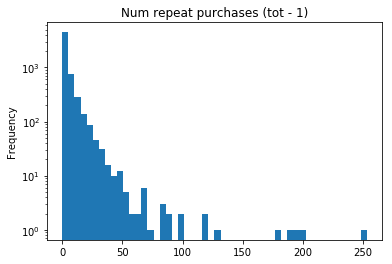

In [17]:
tit='Num repeat purchases (tot - 1)'
RFM_total['frequency'].plot(kind='hist',logy=True,bins=50,title=tit)

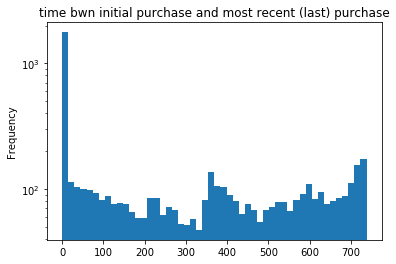

In [18]:
tit='time bwn initial purchase and most recent (last) purchase'
RFM_total['recency'].plot(kind='hist',logy=True,bins=50,title=tit)

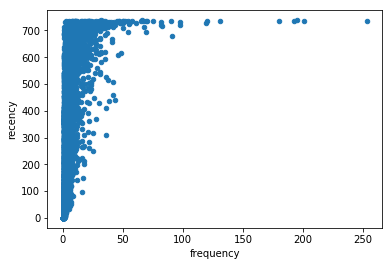

In [19]:
RFM_total.plot.scatter(x='frequency',y='recency')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c7c3b9950>,
      dtype=object)

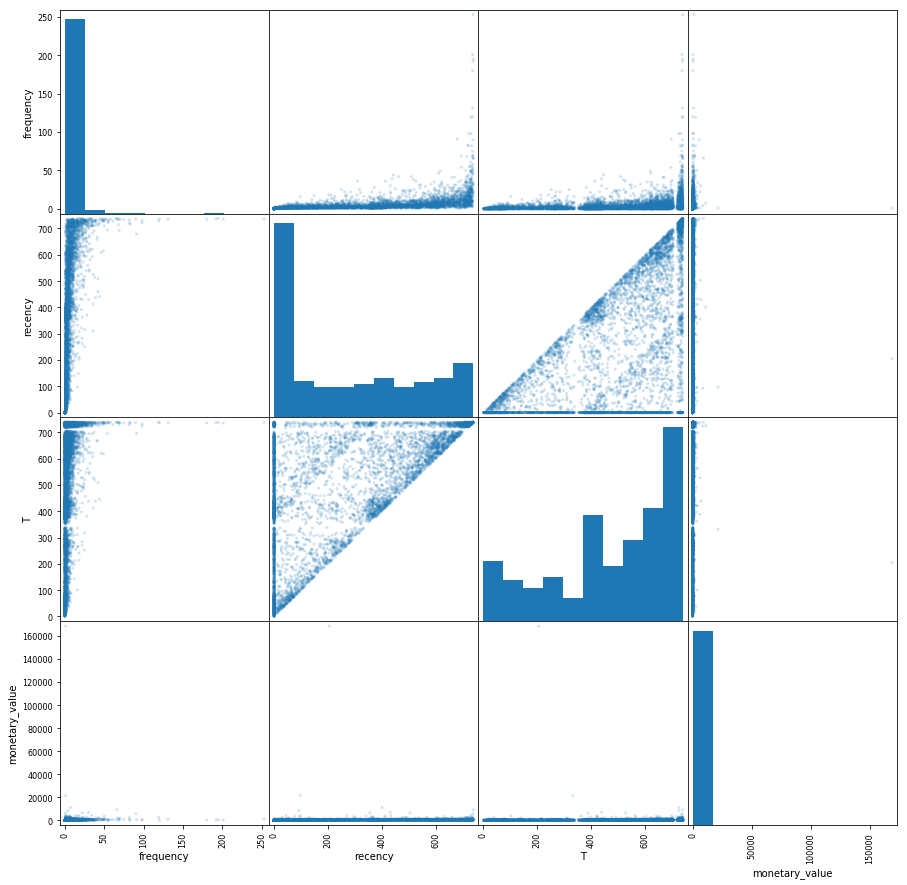

In [20]:
pd.plotting.scatter_matrix(RFM_total, alpha=0.2,figsize=(15,15))

# Assumptions of the BG/NBD model:
- A customer’s relationship has two phases: “alive” for an unobserved period of time, then “dead”
- While alive, the number of transactions made by a customer follows a Poisson distribution with transaction rate lambda
- Heterogeneity in lambda follows a gamma distribution
- After any transaction, a customer dies with probability p; the probability that a customer dies after a number of transactions follows a geometric distribution
- p follows a beta distribution
- Lambda and p vary independently across customers

# Seen these references
- https://medium.com/data-shopify/how-shopify-merchants-can-measure-retention-c12284bfed6f
- http://brucehardie.com/papers/bgnbd_2004-04-20.pdf (of which I have other url's as well)

# First technical tests
- familiarise with the model object BetaGeoFitter
- familiarise with the tools from the lifetime package 

In [82]:
# help(BetaGeoFitter)

In [22]:
beta_play = BetaGeoFitter(penalizer_coef=0.0)
beta_play.fit(RFM_total['frequency'], RFM_total['recency'], RFM_total['T']);

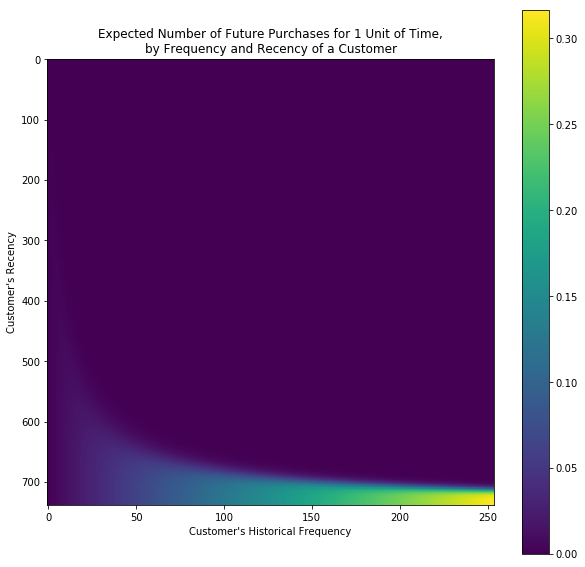

In [23]:
# https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/plotting.py#L211
fig = plt.figure(figsize=(10,10))
plot_frequency_recency_matrix(beta_play);

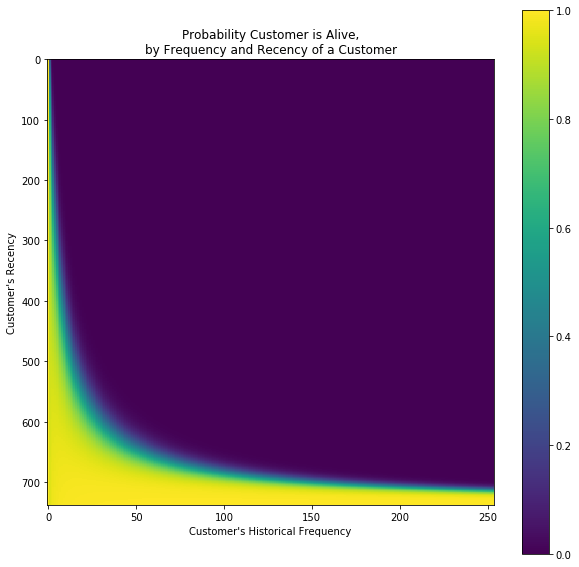

In [24]:
fig = plt.figure(figsize=(10,10))

plot_probability_alive_matrix(beta_play);

# compare for _number of transactions_ :
- prediction from the model, over period used for its fit
- the actual data, over the period used for its fit
## NOTE: this is a game done for the whole dataset, it's to learn how to play

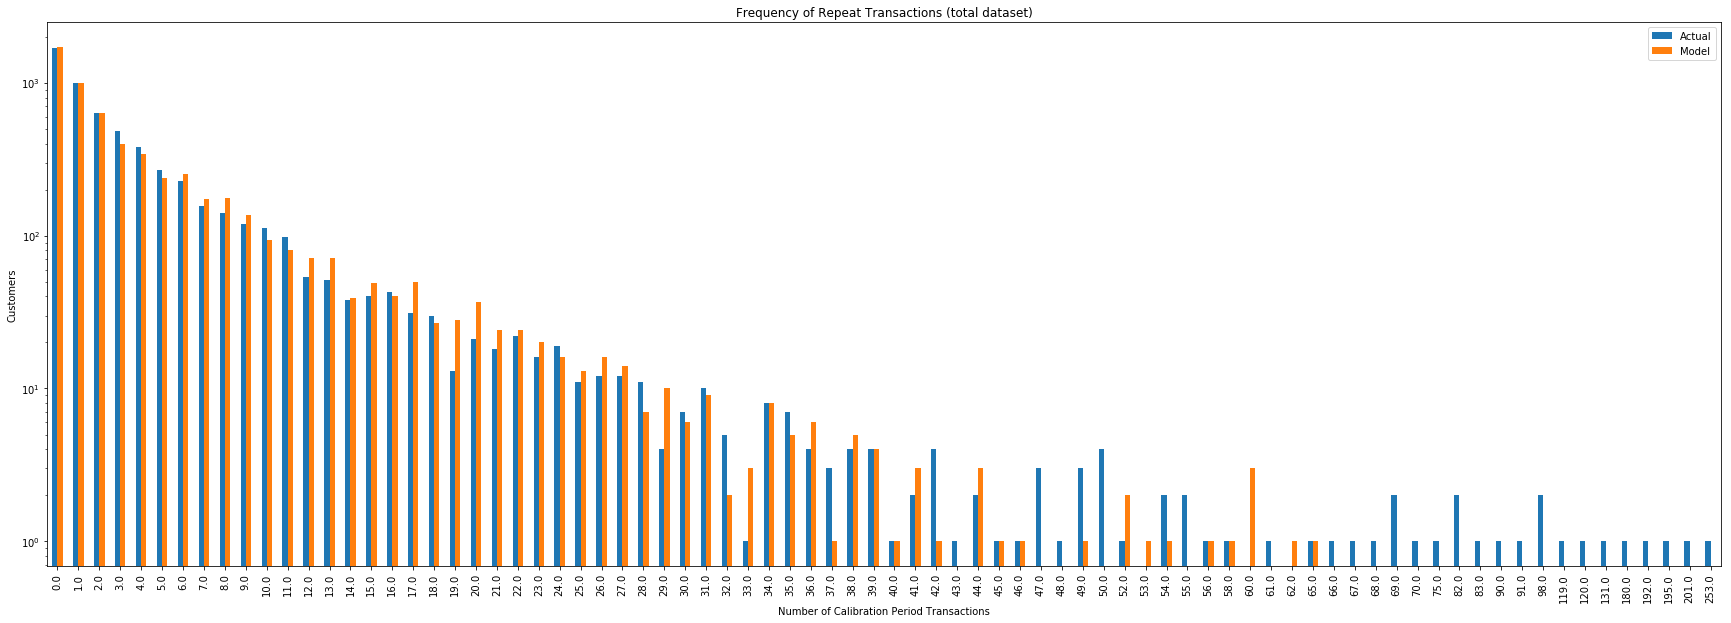

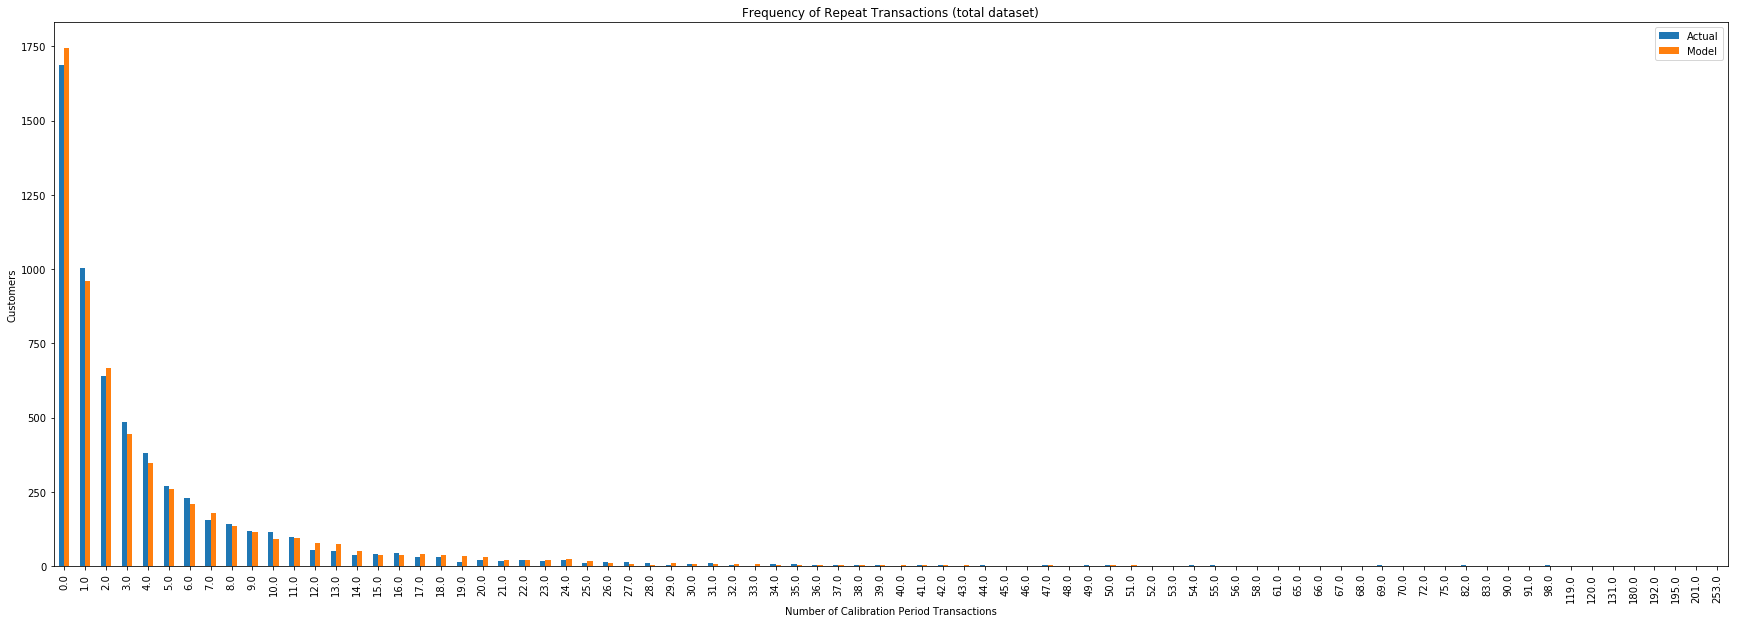

In [25]:
mf  = 100
for ly in [True,False]:
    # https://github.com/CamDavidsonPilon/lifetimes/blob/fb047f7471f07ca4416ddffdfeeca898404cda79/lifetimes/plotting.py#L25
    plot_period_transactions(beta_play, max_frequency=mf
                        ,title="Frequency of Repeat Transactions (total dataset)"
                        ,xlabel="Number of Calibration Period Transactions"
                        ,ylabel="Customers"
                        ,logy=ly
                        ,figsize=(30,10)    )

<a id="section_churn_upToJune"></a>

# SEPARATE 
## data up-to June 2011 (calibration),
## from the whole dataset up to december (total)
- here we really start to implement the Analysis STRATEGY reported above

In [26]:
data_star='2009-12-01'
calib_end='2011-06-30'
obser_end='2011-12-09'

from datetime import date
d_data_star=date( * map(lambda u:int(u), data_star.split('-') ) )
d_calib_end=date( * map(lambda u:int(u), calib_end.split('-') ) )
d_obser_end=date( * map(lambda u:int(u), obser_end.split('-') ) )

data_span = (d_obser_end - d_data_star).days
data_train= (d_calib_end - d_data_star).days
print('Data cover %d days overall, of which %d are used for training'%(data_span,data_train))

Data cover 738 days overall, of which 576 are used for training


In [27]:
# https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/utils.py#L27

#  Create a summary of each customer over a calibration and test period.    
summary_cal_test = calibration_and_holdout_data(df_forRFM,'Customer_ID','InvoiceDate',
                                                    calibration_period_end=calib_end,
                                                    observation_period_end=obser_end)

summary_cal_test.shape

(5036, 5)

# XCHECK THIS SELECTION

In [28]:
#summary_cal_test = summary_cal_test.loc[summary_cal_test['frequency_cal']>0]
#summary_cal_test.shape

In [29]:
summary_cal_test.sort_values(by=['frequency_cal'],ascending=False).head(5)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer_ID,,,,,
14911.0,180.0,575.0,576.0,73.0,162
15311.0,153.0,575.0,576.0,41.0,162
14606.0,144.0,573.0,574.0,36.0,162
12748.0,139.0,571.0,573.0,61.0,162
17841.0,131.0,572.0,575.0,61.0,162


# Fit the Beta-Geometric/NBD model, restricted up to June 2011
- restrict data up to the first semester of 2011
- fit the Beta-Geometric/NBD over that period
- use the remaining 6 months to qualify the fit

In [30]:
beta_NDB_calib = BetaGeoFitter(penalizer_coef=0.0)

# The model is fit only using data up to the end of June 2011
beta_NDB_calib.fit(summary_cal_test['frequency_cal'] \
            ,summary_cal_test['recency_cal'] \
            ,summary_cal_test['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 5036 subjects, a: 0.16, alpha: 64.80, b: 3.23, r: 0.66>

<a id="section_churn_validation_upToJune"></a>

# Validation of the Beta-Geometric/NBD model
- calibrated on the first segment of data (first 1,5 year), and evaluated on the last 6 months
- the last 6 months act as test against the predictions from the first 1.5 y

# compare for _number of transactions_ :
- prediction from the model, over period used for its fit (Calib only, up to June 2011)
- the actual data, over the period used for its fit

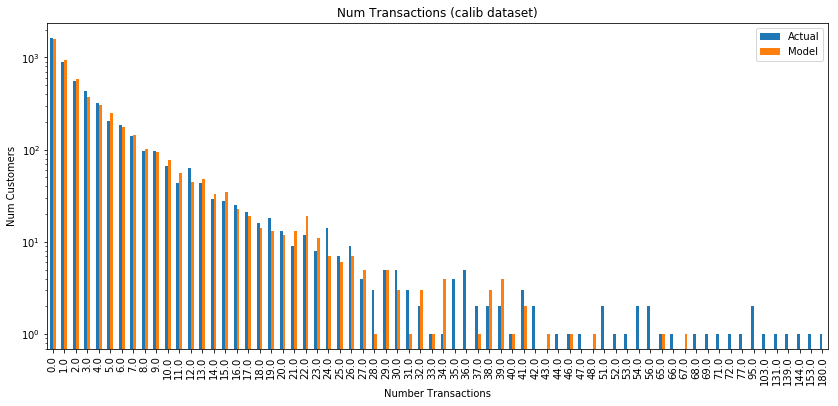

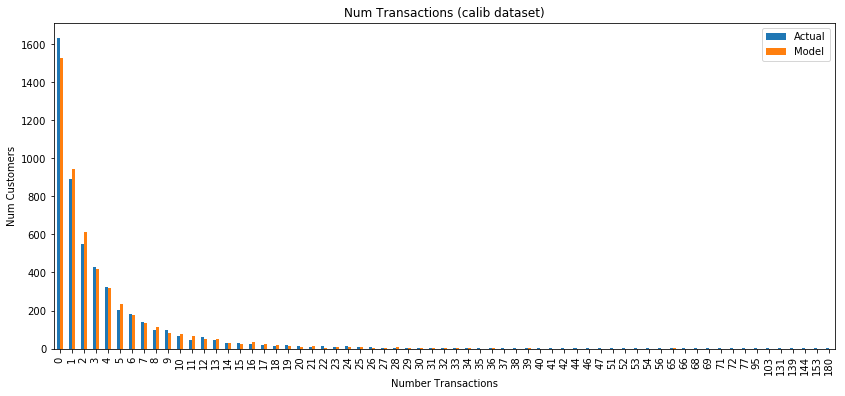

In [31]:
mf  = 100
for ly in [True,False]:
    # https://github.com/CamDavidsonPilon/lifetimes/blob/fb047f7471f07ca4416ddffdfeeca898404cda79/lifetimes/plotting.py#L25
    plot_period_transactions(beta_NDB_calib, max_frequency=mf
                        ,title="Num Transactions (calib dataset)"
                        ,xlabel="Number Transactions"
                        ,ylabel="Num Customers"
                        ,logy=ly
                        ,figsize=(14,6)    )

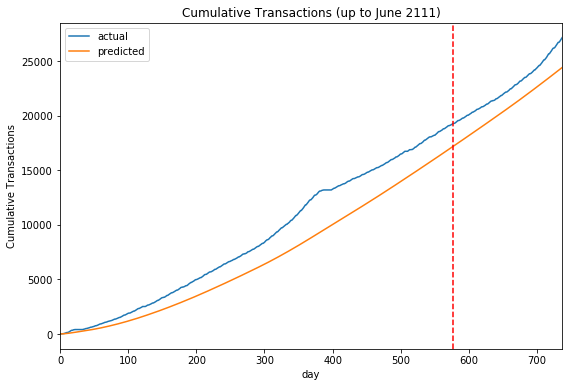

In [32]:
fig = plt.figure(figsize=(9,6))
plot_cumulative_transactions(beta_NDB_calib, df_forRFM\
                             ,'InvoiceDate', 'Customer_ID'
                             ,data_span, data_train
                             ,title="Cumulative Transactions (up to June 2111)"
                             ,xlabel="day"
                             ,ylabel="Cumulative Transactions",)

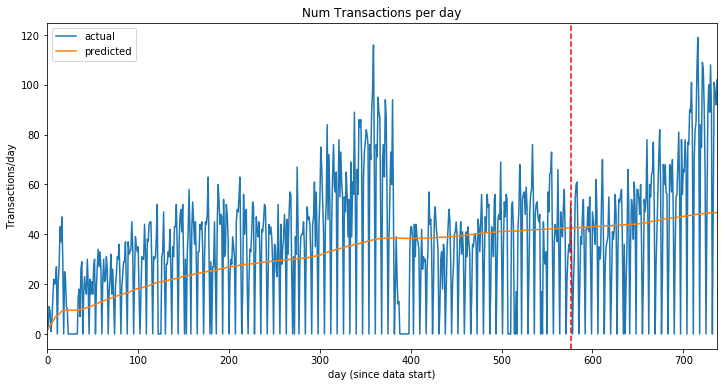

In [34]:
# calls plot_cumulative_transactions
# which in turns uses
#    expected_number_of_purchases_up_to_time()
#    method from the fitted model
#    to predict the cumulative number of purchases.

fig = plt.figure(figsize=(12,6))
plot_incremental_transactions(beta_NDB_calib, df_forRFM
                             ,'InvoiceDate', 'Customer_ID'
                             ,data_span, data_train
                             ,freq='D'
                             ,title="Num Transactions per day"
                             ,xlabel="day (since data start)"
                             ,ylabel="Transactions/day",)

In [35]:
# The function

#             plot_calibration_purchases_vs_holdout_purchases
#             https://github.com/CamDavidsonPilon/lifetimes/blob/fb047f7471f07ca4416ddffdfeeca898404cda79/lifetimes/plotting.py#L77

# uses internally

#             conditional_expected_number_of_purchases_up_to_time
#             help(conditional_expected_number_of_purchases_up_to_time)
#             https://github.com/CamDavidsonPilon/lifetimes/blob/3e93e805ccb9b4660bd2609a7a9491237029547e/lifetimes/fitters/beta_geo_beta_binom_fitter.py#L179
# from the paper:
# for the expected number of transactions in a future period of length t for an individual with past observed behavior 

# to predict into the TEST period using the model,
# and plots the average purchase frequency in bins of other variables --<'kind'


## the plots have on ABCISSA bins of variables computed in the CALIBRATION period:

- k="frequency_cal"               # Purchases in calibration period,
- k="recency_cal"                 # Age of customer at last purchase,
- k="T_cal"                       # Age of customer at the end of calibration period,
- k="time_since_last_purchase"    # Time since user made last purchase

## the plots have on ordinate the average number of purchases over the TEST period:
- from the real data (the truth for this test)
- from the prediction


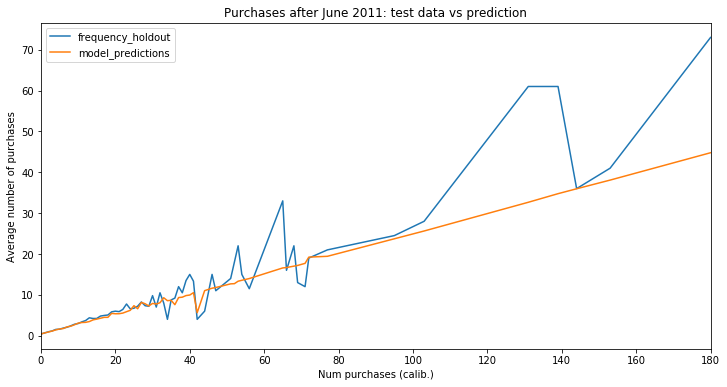

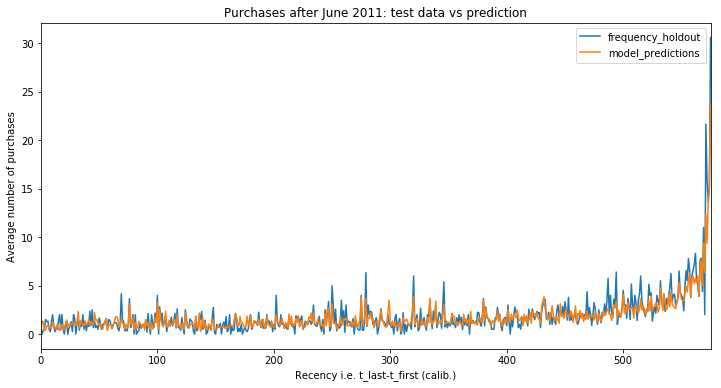

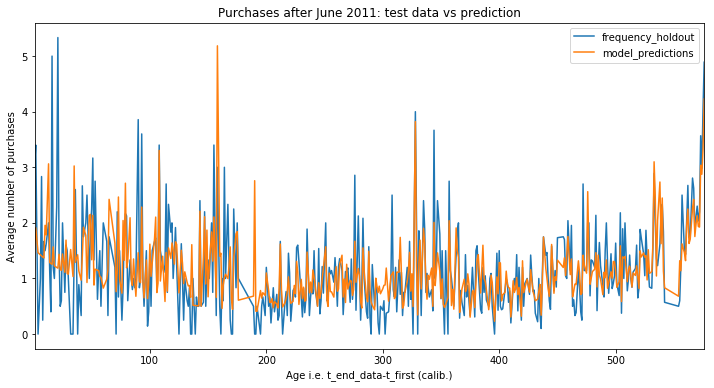

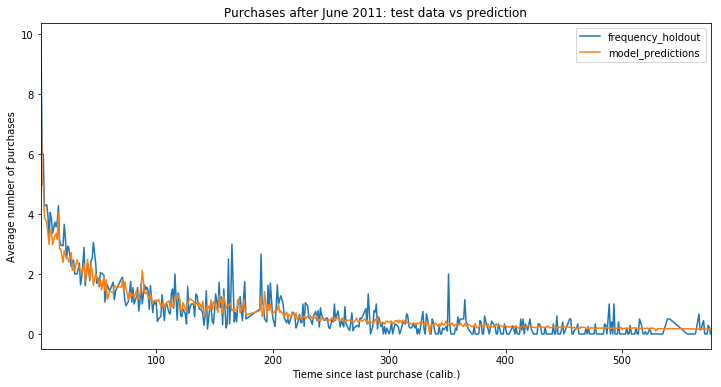

In [36]:
ymax=8000
for k,xlab in [['frequency_cal','Num purchases (calib.)'],
            ['recency_cal','Recency i.e. t_last-t_first (calib.)'],
            ['T_cal','Age i.e. t_end_data-t_first (calib.)'],
            ['time_since_last_purchase','Tieme since last purchase (calib.)'],]:
                plot_calibration_purchases_vs_holdout_purchases(beta_NDB_calib
                                                    ,summary_cal_test
                                                    ,n=ymax # huge value => always all points 
                                                    ,figsize=(12,6)
                                                    ,title="Num Transactions per day"
                                                    ,kind=k )
                plt.title('Purchases after June 2011: test data vs prediction')
                plt.xlabel(xlab)
                plt.ylabel('Average number of purchases')


In [37]:
summary_cal_test.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer_ID,,,,,
12346.0,7.0,400.0,563.0,0.0,162
12347.0,4.0,221.0,242.0,3.0,162
12348.0,3.0,190.0,276.0,1.0,162
12349.0,2.0,182.0,427.0,1.0,162
12350.0,0.0,0.0,148.0,0.0,162


In [38]:
RFM_total.head()

,frequency,recency,T,monetary_value
Customer_ID,,,,
12346.0,7.0,400.0,725.0,11066.637143
12347.0,7.0,402.0,404.0,717.398571
12348.0,4.0,363.0,438.0,449.310000
12349.0,3.0,571.0,589.0,1120.056667
12350.0,0.0,0.0,310.0,0.000000


In [39]:
# the following cell can be removed once I'll have put the 
# prob_alive somewhere else

Text(0.5,0,'Frequency')

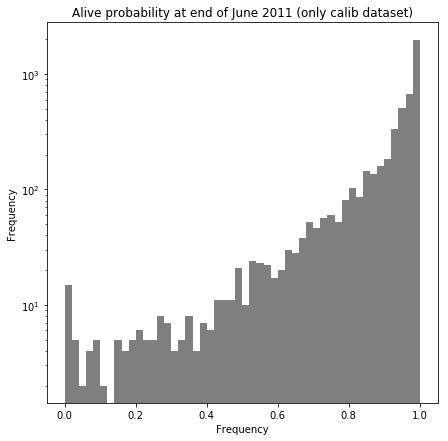

In [40]:
# select only the customers who have come back already at least once
# RFM_returned = RFM_total[RFM_total['frequency']>0]

summary_cal_test['prob_alive'] = \
 beta_NDB_calib.conditional_probability_alive(summary_cal_test['frequency_cal'],
                                               summary_cal_test['recency_cal'],
                                               summary_cal_test['T_cal'])

tit='Alive probability at end of June 2011 (only calib dataset)'
r=(0,1)
summary_cal_test.prob_alive.plot(kind='hist',logy=True, \
                title=tit,bins=50,range=r,colormap='copper',alpha=0.5,figsize=(7,7))
plt.xlabel('Frequency') 

In [41]:
summary_cal_test.prob_alive.describe()

count    5.036000e+03
mean     9.066476e-01
std      1.532778e-01
min      6.989990e-07
25%      8.889289e-01
50%      9.642703e-01
75%      1.000000e+00
max      1.000000e+00
Name: prob_alive, dtype: float64

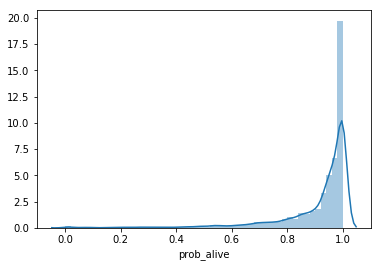

In [42]:
sns.distplot(summary_cal_test['prob_alive'])

<a id="section_churn_fulldataset"></a>

# Fit the Beta-Geometric/NBD model, FULL Dataset                  (up to end December 2011)
- consider the whole dataset
- fit the Beta-Geometric/NBD over that period
- there''s no test perdiod for this model; we assume that the good accuracy observed when fitting over the limited period supports the validity of the model also over the whole pariod

Text(0.5,0,'Frequency')

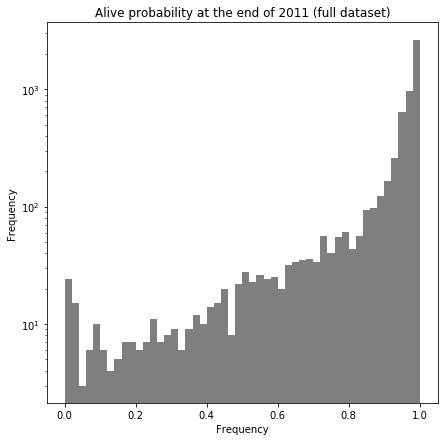

In [43]:
# Create a summary of each customer over the whole calibration period
# to implement that, set the end of the calibration period 3 days before the end of dataset
calib_end='2011-12-07'

summary_full_period = calibration_and_holdout_data(df_forRFM,'Customer_ID','InvoiceDate',
                                                    calibration_period_end=calib_end,
                                                    observation_period_end=obser_end)

# The model is fit trougouht the whole dataet
beta_NDB_total = BetaGeoFitter(penalizer_coef=0.0)

beta_NDB_total.fit(summary_full_period['frequency_cal'] \
            ,summary_full_period['recency_cal'] \
            ,summary_full_period['T_cal'])

RFM_total['prob_alive_total'] = \
       beta_NDB_total.conditional_probability_alive(RFM_total['frequency'],
                                        RFM_total['recency'],
                                        RFM_total['T'])


tit='Alive probability at the end of 2011 (full dataset)'
r=(0,1)
RFM_total.prob_alive_total.plot(kind='hist',logy=True, \
                title=tit,bins=50,range=r,colormap='copper',alpha=0.5,figsize=(7,7))
plt.xlabel('Frequency') 

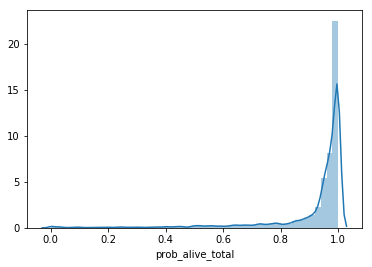

In [44]:
sns.distplot(RFM_total['prob_alive_total'])

In [45]:
RFM_total.describe()

,frequency,recency,T,monetary_value,prob_alive_total
count,5875.000000,5875.000000,5875.000000,5875.000000,5.875000e+03
mean,4.633191,273.487149,474.274383,317.113424,9.123291e-01
std,9.993993,258.975061,223.072007,2254.409792,1.689250e-01
min,0.000000,0.000000,0.000000,0.000000,2.356996e-10
25%,0.000000,0.000000,313.000000,0.000000,9.297382e-01
50%,2.000000,221.000000,530.000000,213.555000,9.749926e-01
75%,5.000000,512.000000,668.000000,376.168333,1.000000e+00
max,253.000000,738.000000,738.000000,168469.600000,1.000000e+00


In [46]:
summary_full_period.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,5869.000000,5869.000000,5869.000000,5869.000000,5869.0
mean,4.599080,272.141591,472.758051,0.033055,2.0
std,9.924319,258.074288,222.672182,0.181632,0.0
min,0.000000,0.000000,1.000000,0.000000,2.0
25%,0.000000,0.000000,314.000000,0.000000,2.0
50%,2.000000,219.000000,528.000000,0.000000,2.0
75%,5.000000,510.000000,666.000000,0.000000,2.0
max,251.000000,735.000000,736.000000,2.000000,2.0


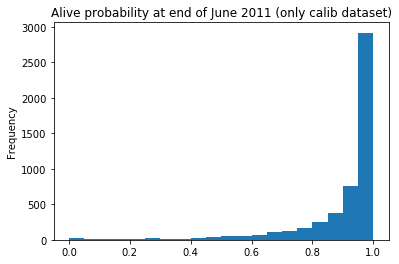

In [47]:
tit='Alive probability at end of June 2011 (only calib dataset)'
summary_cal_test['prob_alive'].plot(kind='hist',bins=20,title=tit)

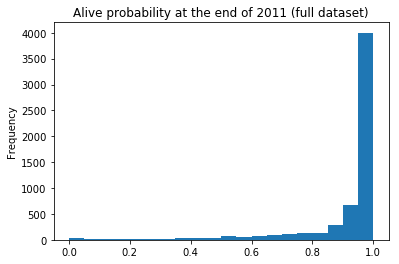

In [48]:
tit='Alive probability at the end of 2011 (full dataset)'
RFM_total['prob_alive_total'].plot(kind='hist',bins=20,title=tit)

/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


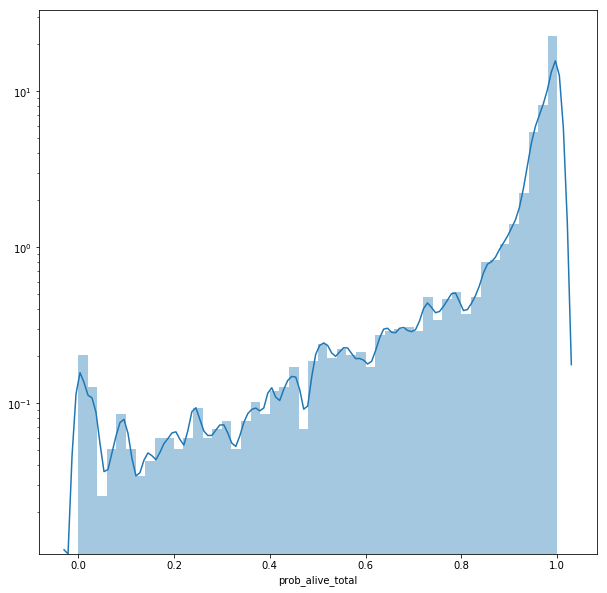

In [49]:
fig = plt.figure(figsize=(10,10))
sns.distplot(RFM_total['prob_alive_total'], hist_kws={'log':True})

In [50]:
# merge dataframes such that prob_alive_total and prob_alive are available in the same df

In [51]:
summary_cal_test.head(1)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,prob_alive
Customer_ID,,,,,,
12346.0,7.0,400.0,563.0,0.0,162,0.851804


In [52]:
RFM_total.head(1)

,frequency,recency,T,monetary_value,prob_alive_total
Customer_ID,,,,,
12346.0,7.0,400.0,725.0,11066.637143,0.563418


In [53]:
summary_final=summary_cal_test.join(RFM_total[['prob_alive_total','frequency','recency','T']])

In [54]:
type(summary_final)

pandas.core.frame.DataFrame

In [55]:
summary_final.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,prob_alive,prob_alive_total,frequency,recency,T
count,5036.000000,5036.000000,5036.000000,5036.000000,5036.0,5.036000e+03,5.036000e+03,5036.000000,5036.000000,5036.000000
mean,3.816720,200.060365,379.412431,1.429110,162.0,9.066476e-01,9.019794e-01,5.251589,314.545473,541.412431
std,8.092708,195.734655,161.841627,2.962717,0.0,1.532778e-01,1.797282e-01,10.652088,257.260805,161.841627
min,0.000000,0.000000,1.000000,0.000000,162.0,6.989990e-07,2.356996e-10,0.000000,0.000000,163.000000
25%,0.000000,0.000000,256.000000,0.000000,162.0,8.889289e-01,9.132707e-01,1.000000,12.750000,418.000000
50%,1.000000,154.000000,416.000000,1.000000,162.0,9.642703e-01,9.734157e-01,2.000000,317.000000,578.000000
75%,4.000000,374.000000,520.000000,2.000000,162.0,1.000000e+00,9.969554e-01,6.000000,554.000000,682.000000
max,180.000000,575.000000,576.000000,73.000000,162.0,1.000000e+00,1.000000e+00,253.000000,738.000000,738.000000


<a id="section_churn_finalplots"></a>
# Alive probability: full-dataset VS up-to-June2011

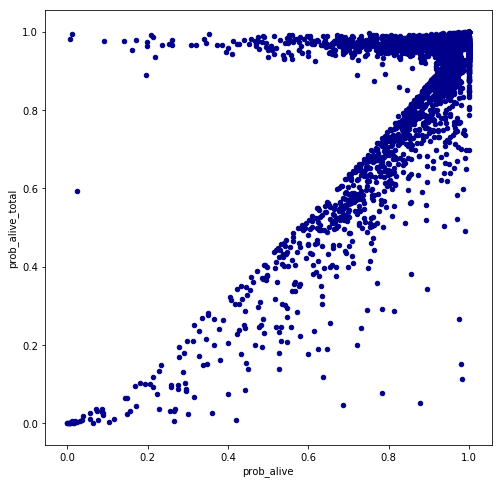

In [56]:
summary_final.plot.scatter(x='prob_alive'
                           ,y='prob_alive_total'
                           ,figsize=(8,8)
                           ,c='DarkBlue')

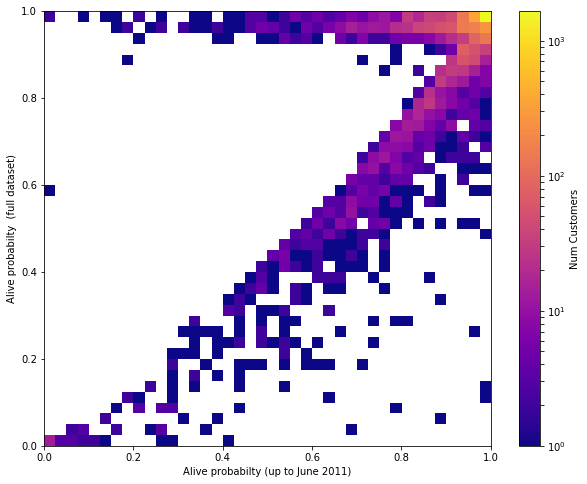

In [68]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(10,8))

plt.hist2d(summary_final['prob_alive']
           , summary_final['prob_alive_total']
           , bins=40
           #, cmap='Blues'
           , cmap='plasma'
           , norm=colors.LogNorm()
          )
plt.xlabel('Alive probabilty (up to June 2011)')
plt.ylabel('Alive probabilty  (full dataset)')

cb = plt.colorbar()
cb.set_label('Num Customers')

In [72]:
# SPOT CHECKS to make sense of the result...
# two customers were dead and 
# have come back to life shortly before the end of 2011, 
# see recency \approx== T, while T_cal very large
summary_final.loc[ (summary_final['prob_alive_total'] > 0.95) & \
                  (summary_final['prob_alive'] < 0.07) ]

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,prob_alive,prob_alive_total,frequency,recency,T
Customer_ID,,,,,,,,,,
16549.0,23.0,287.0,459.0,7.0,162,0.012600,0.994441,30.0,611.0,621.0
16742.0,12.0,231.0,561.0,1.0,162,0.006665,0.982669,13.0,677.0,723.0


In [73]:
churn_up_threshold = 0.10
risk_up_threshold = 0.30

In [74]:
# Answer to question number 1
summary_final.loc[ (summary_final['prob_alive_total'] < churn_up_threshold) & \
                   (summary_final['prob_alive']       > churn_up_threshold) ].describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,prob_alive,prob_alive_total,frequency,recency,T
count,31.000000,31.000000,31.000000,31.0,31.0,31.000000,31.000000,31.000000,31.000000,31.000000
mean,8.129032,207.677419,461.064516,0.0,162.0,0.300612,0.056486,8.129032,207.677419,623.064516
std,4.402590,103.607396,118.278749,0.0,0.0,0.182470,0.031664,4.402590,103.607396,118.278749
min,3.000000,22.000000,220.000000,0.0,162.0,0.103533,0.003456,3.000000,22.000000,382.000000
25%,5.000000,125.500000,397.000000,0.0,162.0,0.188162,0.031265,5.000000,125.500000,559.000000
50%,7.000000,171.000000,494.000000,0.0,162.0,0.264272,0.063717,7.000000,171.000000,656.000000
75%,10.500000,291.500000,565.500000,0.0,162.0,0.307421,0.085772,10.500000,291.500000,727.500000
max,20.000000,432.000000,576.000000,0.0,162.0,0.877311,0.099086,20.000000,432.000000,738.000000


In [75]:
# Answer to question number 2
summary_final.loc[ (summary_final['prob_alive_total'] > churn_up_threshold) & \
                   (summary_final['prob_alive_total'] < risk_up_threshold) ].describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,prob_alive,prob_alive_total,frequency,recency,T
count,68.000000,68.000000,68.000000,68.000000,68.0,68.000000,68.000000,68.000000,68.000000,68.000000
mean,4.691176,150.955882,443.500000,0.073529,162.0,0.474308,0.210297,4.764706,152.029412,605.500000
std,4.012136,127.082584,134.354677,0.498241,0.0,0.181454,0.055537,4.103576,126.929052,134.354677
min,1.000000,1.000000,35.000000,0.000000,162.0,0.181728,0.100263,1.000000,1.000000,197.000000
25%,2.000000,59.750000,340.500000,0.000000,162.0,0.343692,0.170663,2.000000,62.500000,502.500000
50%,3.000000,107.500000,487.000000,0.000000,162.0,0.446348,0.212929,3.000000,107.500000,649.000000
75%,6.000000,237.500000,564.000000,0.000000,162.0,0.549513,0.251011,6.000000,237.500000,726.000000
max,24.000000,506.000000,576.000000,4.000000,162.0,0.982741,0.296052,24.000000,506.000000,738.000000


## Have any users churned during the second half of 2011? 
- I define them as users who have a low prob of being alive at the end of 2011 and had higher prob mid 2011

## Are there any users at high risk of churning by the end of 2011?
- users who have low live probabiliy at the end of 2011 and didn't mid 2011 

- split the users in three populations: dead, alive, high rish
- answer to first  question: number of users who were alive|risk in may 2011 and are dead at the end of 2011
- answer to second question: number of users who are at high risk at the end of 2011

## no need of splitting the customers to train/apply: I just train and verify goodness on variables other than those used. THERE IS NO GROUND TRUTH available in the training data